当我们计算平衡浓度时，我们通常可以使用ICE表创建一个多项式方程，然后求解得到的方程。然而，这种方法并不总是有效，特别是当发生多种影响平衡浓度的反应时。在这些情况下，我们需要同时求解多个方程，这些方程通常是非线性的。在本笔记本中，我们将以氯化银的溶解度为例，了解如何做到这一点。首先，导入依赖项：

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

在我们进行更复杂的计算之前，让我们计算一下AgCl在纯水中的溶解度。总溶解度反应为：
$$\textrm{AgCl} \rightarrow \textrm{Ag}^{+}_{(aq)} + \textrm{Cl}^{-}_{(aq)} \qquad \textrm{K}_{sp} = 1.82 \textrm{x} 10^{-10}$$  
可能最简单的方法是编写一个可以求解二次方程的函数（我命名为quad_solve），然后用它来求解 [Ag +
 ]。为此，求解二次方程有点矫枉过正，但在下一步中是必要的。提醒一下，函数（无论是数学函数还是计算机函数）是接受一些输入，以某种方式操作它们，然后返回操纵结果的东西。要用python编写一个函数，我们首先定义它（使用“def”关键字），然后作为函数一部分的所有行都插入1个选项卡，然后我们使用“return”关键字告诉函数要返回什么。请注意，我在下面编写的二次函数求解器返回两个根，因此我们在选择所需的根时需要小心。

从ICE表中我们知道 [Ag$^{+}$][Cl$^{-}$] = 1.82 x 10$^{-10}$, [Ag$^{+}$] = [Cl$^{-}$], 所以 [Ag$^{+}$]$^{2}$ = 1.82 x 10$^{-10}$. 这意味着，对于二次方程， a = 1, b = 0, c = -1.82 x 10$^{-10}$ （您可能需要仔细检查这一点，以便了解这些数字的来源）。

In [3]:
def quad_solve(a, b, c):
    discrim = np.sqrt(b**2 - 4 * a * c)
    sol1 = (-b + discrim)/(2 * a)
    sol2 = (-b - discrim)/(2 * a)
    return [sol1,sol2]

solutions = quad_solve(1,0,-1.82E-10)
corrsol="{:.2E}".format(solutions[0])
print("The solubility of AgCl in pure water is",corrsol)

The solubility of AgCl in pure water is 1.35E-05


现在让我们考虑常见的离子效应，并计算AgCl在0.1M KCl中的溶解度。在这种情况下，ICE 表给出 a = 1，b = 0.1，c = -1.82 x 10 −10
 .希望您现在可以了解为什么二次求解器函数很有用。同样，你应该做一个ICE表来仔细检查我的数字。您还应该检查两个根，以确保我在下面选择的根是正确的。

In [3]:
solutions = quad_solve(1,0.1,-1.82E-10)
corrsol="{:.2E}".format(solutions[0])
print("The solubililty of AgCl in 0.1M KCl is",corrsol)

The solubililty of AgCl in 0.1M KCl is 1.82E-09


现在我们可以绘制 AgCl 在 KCl 溶液中的溶解度与 KCl 浓度的函数关系，从 0 到 0.1 M。在python中绘制图形的最简单方法是创建一个表示x和y值的点的二维列表，类似于我们在之前的笔记本中对校准曲线所做的。因此，我将使用 numpy 包中的 linspace（） 函数来创建一组均匀分布在 0.00001 和 0.1 之间的 100 个点，以用作我的不同 KCl 浓度（这将是 x 点），然后使用我上面写的带有这些 x 点的四解函数来找到 AgCl 的溶解度（这将是 y 点）。然后，我可以使用 matlibpyplot 包中的 plot（） 函数绘制这些 x，y 点。

In [2]:
datapts = 100

xrange = np.linspace(.00001,0.1,num=datapts)
yrange = quad_solve(1,xrange,-1.82E-10)

plt.plot(xrange, np.log10(yrange[0]), 'ro')
plt.title("Figure 1 - Silver chloride concentration vs potassium chloride concentration")
plt.xlabel('KCl concentration (moles/liter)')
plt.ylabel('Log silver solubility')
plt.show()

NameError: name 'quad_solve' is not defined

如您所见，当KCl浓度等于0M且为0.1M时，氯化银的溶解度是我们上面计算的，其行为是我们对普通离子效应的预期。不幸的是，如果我们需要同时求解多个方程，这对我们没有帮助。那么，我们如何做到这一点呢？我将使用来自 scipy 包的 fsolve（） 函数，而不是我写的二次方程来查找 [Ag +
 ].这比我上面所做的工作要多，但从长远来看会得到回报。

fsolve（） 函数使用迭代过程来查找一组方程的解，并处理非线性方程。对于这个问题，我们有三个未知数（[Ag +
 ]， [Cl −
 ] 和 [K +
 ]），因此我们需要提出三个方程。我们还需要为 fsolve（） 提供一个猜测，我将使用初始条件作为猜测。为了做到这一点，我将从一个KCl浓度开始，0.1 M。因此，我的初始状态是：[Ag +
 ] = 0， [Cl −
 ] = [K +
 ] = 0.1 m。此外，因为 fsolve（） 需要一个函数的输入，我需要编写一个函数，我将调用它 AgCl_sol（），它返回三个方程。

In [3]:
initAg = 0
initCl = initK = 0.1

initparams = (initAg, initCl, initK)

def AgCl_sol(concentrations):
    (Ag_conc, Cl_conc, K_conc) = concentrations
    
    firstEq = Ag_conc * Cl_conc - 1.82E-10
    secondEq = Ag_conc + K_conc - Cl_conc
    thirdEq = K_conc - K_conc
    
    return[firstEq, secondEq, thirdEq]

solution = opt.fsolve(AgCl_sol,initparams)

solubility = "{:.2E}".format(solution[0])

print("At a KCl concentration of", initK, "AgCl solubility is", solubility)

At a KCl concentration of 0.1 AgCl solubility is 1.82E-09


看看我上面写的AgCl_sol（）函数。第一个方程从何而来？

第二个方程从何而来？

第三个方程告诉计算机什么？

你会注意到，对于这三个，我都操纵了它们，所以我有一个等于零的方程。这是 fsolve（） 函数的要求。

现在，我可以使用上面创建的函数和 fsolve（） 函数来计算和绘制 AgCl 在 KCl 中的溶解度，KCl 浓度范围从接近零到 0.1 M。我不能从零开始，因为我编写的函数会遇到奇怪的问题。因为我正在处理大范围的值，所以我决定使用沿对数轴均匀分布的 x 点，而不是线性轴，所以我使用 numpy 包中的 logspace（） 函数来创建我的 x 范围。否则，它与我上面所做的非常相似。

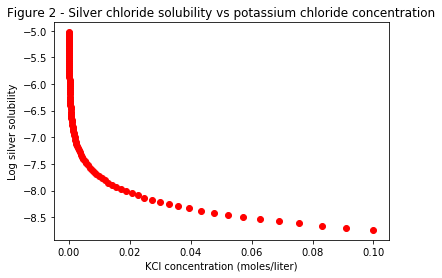

In [11]:
logxrange = np.logspace(-5,-1,num=datapts)

#Below is my starting points, with Ag+ = 0, K+ and Cl- = x-range
guess_array = tuple(zip(np.zeros(datapts),logxrange,logxrange)) 

out_array = []
silver_conc = []
chloride_conc = []
potassium_conc = []

for num in range(0,datapts):
    out_array.append(list(opt.fsolve(AgCl_sol,guess_array[num])))
    silver_conc.append(out_array[num][0])
    chloride_conc.append(out_array[num][1])
    potassium_conc.append(out_array[num][2])

plt.plot(potassium_conc,np.log10(silver_conc),'ro')
plt.title("Figure 2 - Silver chloride solubility vs potassium chloride concentration")
plt.xlabel('KCl concentration (moles/liter)')
plt.ylabel('Log silver solubility')
plt.show()

对于相同的答案，这比编写二次公式函数要多得多，也更具挑战性。那么，我为什么要用fsolve完成所有这些工作呢？好吧，现在我们可以对多个非线性方程使用求解，这些非线性方程不会简化为二次方程。例如，让我们添加一个额外的反应：
$$\textrm{Ag}^{+}_{(aq)} + \textrm{2 Cl}^{-}_{(aq)} \rightarrow \textrm{AgCl}^{-}_{2(aq)} \qquad \textrm{K}_{F} = 1.78 \textrm{x} 10^{5}$$

现在我们可以使用 fsolve（） 函数来找到 AgCl 的溶解度，同时考虑到这个额外的平衡。首先，让我们找到单个KCl浓度为0.1M时的溶解度。为此，我需要编写一个新函数，我称之为 AgCl_sol2（），它返回四个方程，因为现在有四个未知数（[ Ag+（aq）
 ]， [ Cl−（aq）
 ]， [ AgCl−2（aq）
 ]， [ K+（aq）
 ]).请注意，AgCl 的总溶解度为 [ Ag+（aq）
 ] + [ AgCl−2（水溶液）
 ].

In [4]:
initAg = initAgCl2 = 0
initCl = initK = 0.1

initparams = (initAg, initAgCl2, initCl, initK)

def AgCl_sol2(concentrations):
    (Ag_conc2, AgCl2_conc2, Cl_conc2, K_conc2) = concentrations
    
    firstEq = Ag_conc2 * Cl_conc2 - 1.82E-10
    secondEq = AgCl2_conc2 - Ag_conc2 * Cl_conc2 ** 2 * 1.78E5
    thirdEq = Ag_conc2 + K_conc2 - Cl_conc2 - AgCl2_conc2
    fourthEq = K_conc2 - K_conc2
    
    return[firstEq, secondEq, thirdEq, fourthEq]

solution = opt.fsolve(AgCl_sol2,initparams)

solubility = "{:.2E}".format(solution[0] + solution[1])

print("At a KCl concentration of", initK, "AgCl solubility is", solubility)

At a KCl concentration of 0.1 AgCl solubility is 3.24E-06


现在它在单一的KCl浓度下工作，我们可以结合我们迄今为止所做的工作，并绘制一系列KCl浓度下的银溶解度！

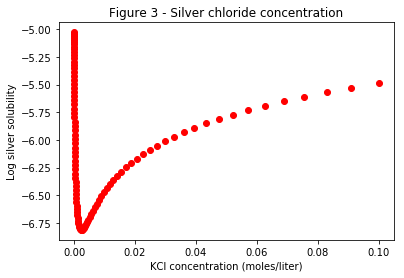

In [12]:
#Below is my starting points, with Ag+ = AgCl2- = 0, K+ and Cl- = x-range
guess_array2 = tuple(zip(np.zeros(datapts),np.zeros(datapts),logxrange,logxrange))

out_array2 = []
silver_conc2 = []
silverchloride_conc2 = []
chloride_conc2 = []
potassium_conc2 = []

for num in range(0,datapts):
    out_array2.append(list(opt.fsolve(AgCl_sol2,guess_array2[num])))
    silver_conc2.append(out_array2[num][0])
    silverchloride_conc2.append(out_array2[num][1])    
    chloride_conc2.append(out_array2[num][2])
    potassium_conc2.append(out_array2[num][3])

total_solubility = np.add(silver_conc2, silverchloride_conc2)

plt.plot(potassium_conc2,np.log10(total_solubility),'ro')
plt.title("Figure 3 - Silver chloride concentration")
plt.xlabel('KCl concentration (moles/liter)')
plt.ylabel('Log silver solubility')
plt.show()

在这里，我们看到氯化银溶解度的行为与我们上面预测的非常不同，这些行为实际上与实验观察到的行为一致。

让我们让它更复杂一点，并添加一个额外的反应：

$$\textrm{AgCl}^{-}_{2(aq)} + \textrm{Cl}^{-}_{(aq)} \rightarrow \textrm{AgCl}^{2-}_{3(aq)} \qquad \textrm{K}_{F} = 2.34$$

现在，轮到你了。找到单个 KCl 浓度为 0.1 M 时的溶解度，说明所有三个反应。从下面的框中开始，使用 fsolve（） 函数在考虑第三个平衡的情况下找到 AgCl 的溶解度，类似于上面的工作。为此，您需要编写一个新函数，我们将其称为 AgCl_sol3（），它返回五个方程，因为现在有五个未知数([$\textrm{Ag}^{+}_{(aq)}$], [$\textrm{Cl}^{-}_{(aq)}$], [$\textrm{AgCl}^{-}_{2(aq)}$], [$\textrm{AgCl}^{2-}_{3(aq)}$], [$\textrm{K}^{+}_{(aq)}$]). 您还需要小心一点，因为 AgCl 溶解度现在将是[$\textrm{Ag}^{+}_{(aq)}$] + [$\textrm{AgCl}^{-}_{2(aq)}$] + [$\textrm{AgCl}^{2-}_{3(aq)}$], 但是 np.add（） 函数只能接受两个输入。

现在您可以找到 AgCl 在单个 KCl 浓度下的溶解度，绘制 KCl 浓度的银溶解度，从10$^{-5}$ M 至10$^{-1}$ M,与上面类似。

使用您刚刚生成的图表，估计导致最低银溶解度的 KCl 浓度：
